# Sequential A/B Testing

We will focus on conditional SPRT (Sequential Probability Ratio Test).

<u>General steps of conditional SPRT</u>

1. Calculate critical upper and lower decision boundaries
2. Perform cummlative sum of the observation
3. Calculate test statistics(likelihood ratio) for each of the observations
4. Calculate upper and lower limits for exposed group
5. Apply stopping\

<b>Stopping Rule</b>
<li>If the log probability ratio greater than or equal to the upper critical limit then the model reject the null hypothesis with the favor of alternative hypothesis (i.e. accept H1 (conclude that version two is better than version one)) and terminate the test.
<li>If the log probability ratio less than or equal to the lower critical limit then accept the null hypothesis (i.e. conclude that there is no difference between the two groups) and terminate the test.
<li>If neither critical limit is reached, conduct another trial and continue the test.

## 1. Fetch Data
### 1.1. Get libraries 

In [38]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import datetime
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency, beta, binom
from statsmodels.stats.proportion import proportions_ztest
from matplotlib.lines import Line2D
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import math

# to know which filepath to use to get to the source data
import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/AdSmartABdata.csv
../data/control_df.csv
../data/exposed_df.csv


### 1.2. Make the Dataframes to be used in this notebook

In [39]:
# loading the data from the exposed and the control groups

exposed_dataf = pd.read_csv('../data/exposed_df.csv')
control_dataf = pd.read_csv('../data/control_df.csv')

In [40]:
exposed_dataf.head()
exposed_dataf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657 entries, 0 to 656
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   657 non-null    object
 1   experiment   657 non-null    object
 2   date         657 non-null    object
 3   hour         657 non-null    int64 
 4   device_make  657 non-null    object
 5   platform_os  657 non-null    int64 
 6   browser      657 non-null    object
 7   response     657 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 41.2+ KB


### 1.3. Transform Data
(into a form that can be used with the ConditionalSPRT Class)\
The proposed transformations are as follows: 
<li>grouping the data into hours

In [41]:
# the data is already segmented into exposed and control groups
 

In [42]:
# copying dataframes so that we work on their copies

exposed_copy= exposed_dataf.copy(deep=True)
control_copy = control_dataf.copy(deep=True)

In [43]:
# create new column to hold date+hour in both the exposed_copy and control_copy

exposed_copy['date+hour'] = exposed_copy['hour'].map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
control_copy['date+hour'] = control_copy['hour'].map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))


In [44]:
# exposed_copy.head()

In [45]:
exposed_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657 entries, 0 to 656
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   657 non-null    object
 1   experiment   657 non-null    object
 2   date         657 non-null    object
 3   hour         657 non-null    int64 
 4   device_make  657 non-null    object
 5   platform_os  657 non-null    int64 
 6   browser      657 non-null    object
 7   response     657 non-null    int64 
 8   date+hour    657 non-null    object
dtypes: int64(3), object(6)
memory usage: 46.3+ KB


In [46]:
# doesn't work. 
# for later (for code modularisation): find way to incorporate two dataframes as the arguments

# def transform_data(df1):
# # exposed_engagement = exposed_copy['reponse'].to_numpy()
# # control_engagement = control_copy['response'].to_numpy()

# # generate random binomial distribution 


#     exposed_copy['engagement'] = exposed_copy['response'] + exposed_copy['response']
#     control_copy['engagement'] = control_copy['response'] + control_copy['response']

#     exposed_copy['success'] = exposed_copy['response'] 
#     control_copy['success'] = control_copy['response'] 

#     expo_p = sum(exposed_copy['success']) / sum(exposed_copy['engagement'])
#     cont_p = sum(control_copy['success']) / sum(control_copy['engagement'])

#     exposed_engagement = exposed_copy['engagement'].to_numpy()
#     control_engagement = control_copy['engagement'].to_numpy()

#     exposed_copy_ds = np.random.choice([0, 1], size=((np.sum(exposed_engagement)),), p=[expo_p, 1-expo_p])
#     control_copy_ds = np.random.choice([0, 1], size=((np.sum(control_engagement)),), p=[cont_p , 1-cont_p ])

#     return exposed_copy_ds, control_copy_ds

In [ ]:
# generate random binomial distributed data streams

exposed_copy['engagement'] = exposed_copy['response'] + exposed_copy['response']
control_copy['engagement'] = control_copy['response'] + control_copy['response']

exposed_copy['success'] = exposed_copy['response'] 
control_copy['success'] = control_copy['response'] 

expo_p = sum(exposed_copy['success']) / sum(exposed_copy['engagement'])
cont_p = sum(control_copy['success']) / sum(control_copy['engagement'])

exposed_engagement = exposed_copy['engagement'].to_numpy()
control_engagement = control_copy['engagement'].to_numpy()

exposed_copy_ds = np.random.choice([0, 1], size=((np.sum(exposed_engagement)),), p=[expo_p, 1-expo_p])
control_copy_ds = np.random.choice([0, 1], size=((np.sum(control_engagement)),), p=[cont_p , 1-cont_p ])


In [54]:
# ensuring the dataframe has been changed into a datastream

print(len(exposed_copy_ds))
print(len(control_copy_ds))
# control_copy

In [48]:
#REFERENCE
# A Conditional Sequential Test for the Equality of Two Binomial Proportions
# William Q. Meeker, Jr
# Journal of the Royal Statistical Society. Series C (Applied Statistics)
# Vol. 30, No. 2 (1981), pp. 109-115
class ConditionalSPRT:
     
    def __init__(self, x, y, odd_ratio, alpha=0.05, beta=0.10, stop=None):
        self.x = x
        self.y = y
        self.odd_ratio = odd_ratio
        self.alpha = alpha
        self.beta = beta
        self.stop = stop
   
    def run(self):
        res = conditionalSPRT(self.x, self.y, self.odd_ratio,
                              self.alpha, self.beta,
                              self.stop)
        return res
    def resJson(self, res):
        outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits = res
        jsonRes = {
            "name": "Sequential AB testing",
            "outcome": outcome,
            "decsionMadeIndex": k,
            "numberOfObservation": len(n),
            "truncated": truncated,
            "truncateDecision": truncate_decision,        
      
        }
        return jsonRes
    
    def plotExperiment(self, res):
        outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits = res
        lower = limits[:, 0]
        upper = limits[:,1]

        fig, ax = plt.subplots(figsize=(12,7))

        ax.plot(n, x1, label='Cumlative value of yes+no')

        ax.plot(n, lower, label='Lower Bound', linestyle='--')
        ax.plot(n, upper, label='Upper Bound', linestyle='--')

        plt.legend()


        plt.show()

In [49]:
import math
def conditionalSPRT(x,y,t1,alpha=0.05,beta=0.10,stop=None):
    """
    #
    # Meeker's SPRT for matched `x` (treatment) and `y` (control), 
    # both indicator responses, likelihood ratio t1, error rates alpha and beta,
    # and (optionally) truncation after trial stop.
    #
    # The return variable contains these elements:
    #(outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)
    # * outcome:   "continue," "reject null," or "accept null".
    # * n: number observation used for the decsion
    # * k:     Index at which the outcome decision was made (or NA)
    # * l:     lower critical point
    # * u:     upper critical point
    # * truncate_decision: The approximate decision made after truncate point
    # * truncated: If the test was truncated, the value of `n.0`; NA otherwise
    # * x1:       Original data `x`, cumulative
    # * r:         Cumulative sum of x+y
    # * stats:     Series of cumulative sums of log probability ratios
    # * limits:    Two rows giving lower and upper critical limits, respectively
    #
    """
    
    if t1<=1:
        print('warning',"Odd ratio should exceed 1.")
    if (alpha >0.5) | (beta >0.5):
        print('warning',"Unrealistic values of alpha or beta were passed."
                 +" You should have good reason to use large alpha & beta values")
    if stop!=None:
        stop=math.floor(n0)

    def comb(n, k):
        return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

    def lchoose(b, j):
        a=[]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            if len(j)<2:
                j=j[0]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            for k in j:
                n=b
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)
        else:
            n=b
            k=j
            if (0 <= k) & (k<= n):
                a.append(math.log(comb(n,k)))
            else:
                a.append(0)

        return np.array(a)

    def g(x,r,n,t1,t0=1):
        return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

    def h(x,r,n,t=1):
     
        return f(r,n,t,offset=ftermlog(x,r,n,t))

    def f(r,n,t,offset=0):
        upper=max(0,r-n)
        lower=min(n,r)
        rng=list(range(upper,lower+1))
        return np.sum(fterm(rng,r,n,t,offset))

    def fterm(j,r,n,t,offset=0):
        ftlog=ftermlog(j,r,n,t,offset)
        return np.array([math.exp(ex) for ex in ftlog])

    def ftermlog(j,r,n,t,offset=0):
    
        xx=r-j
        lch=lchoose(n,j)
        lchdiff=lchoose(n,xx)
        lg=np.array(j)*math.log(t)
        lgsum=lch+lchdiff
        lgsum2=lgsum+lg
        lgdiff=lgsum2-offset

        return lgdiff

    def logf(r,n,t,offset=0):
     
        z=f(r,n,t,offset)
        if z>0:
            return math.log(z)
        else:
            return np.nan

    def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
     
        offset=ftermlog(math.ceil(r/2),r,n,t1c)
        z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
        a=-math.log(alpha/(1-beta))
        b=math.log(beta/(1-alpha))
        lower=b
        upper=1+a
        return (np.array([lower,upper])+z)/math.log(t1c/t0)

    l=math.log(beta/(1-alpha))
    u=-math.log(alpha/(1-beta))
    sample_size=min(len(x),len(y))
    n=np.array(range(1,sample_size+1))

    if stop!=None:
        n=np.array([z for z in n if z<=stop])
    x1=np.cumsum(x[n-1])
    r=x1+np.cumsum(y[n-1])
    stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g
     #
      # Perform the test by finding the first index, if any, at which `stats`
      # falls outside the open interval (l, u).
      #
    clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
    limits=[]
    for v in clu:
        inArray=[]
        for vin in v:
            inArray.append(math.floor(vin))
        limits.append(np.array(inArray))
    limits=np.array(limits)

    k=np.where((stats>=u) | (stats<=l))
    cvalues=stats[k]
    if cvalues.shape[0]<1:
        k= np.nan
        outcome='Unable to conclude.Needs more sample.'
    else:
        k=np.min(k)
        if stats[k]>=u:
            outcome=f'Exposed group produced a statistically significant increase.'
        else:
            outcome='Their is no statistically significant difference between two test groups'
    if (stop!=None) & (k==np.nan):
      #
      # Truncate at trial stop, using Meeker's H0-conservative formula (2.2).
      # Leave k=NA to indicate the decision was made due to truncation.
      #
        c1=clowerUpper(r,stop,t1,alpha,beta)
        c1=math.floor(np.mean(c1)-0.5)
        if x1[n0]<=c1:
            truncate_decision='h0'
            outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
        else:
            truncate_decision='h1'
            outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
        truncated=stop
    else:
        truncate_decision='Non'
        truncated=np.nan
    return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

In [ ]:
exposed_group = exposed_copy_ds
control_group = control_copy_ds
odd_ratio = 1.01
alpha = 0.05
beta = 0.1

In [50]:
# exposed_group,control_group = transform_data(exposed_copy)
# odd_ratio = 1.01
# alpha = 0.05
# beta = 0.1

In [51]:
conditionalSPRTObj = ConditionalSPRT(exposed_group,control_group, odd_ratio, alpha, beta)

In [52]:
res = conditionalSPRTObj.run()

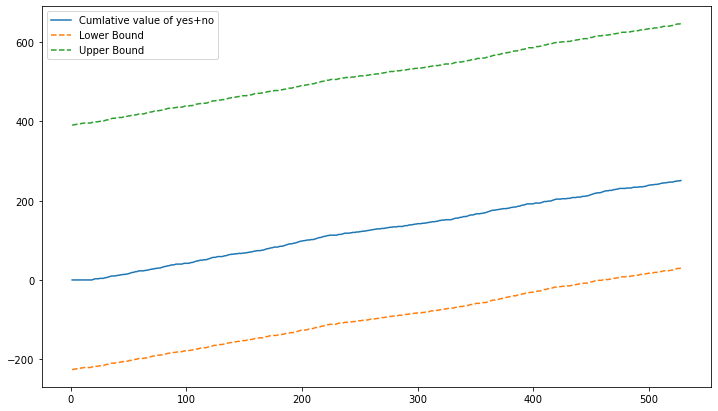

In [53]:
conditionalSPRTObj.plotExperiment(res)

From the plot above, neither Type I Error(exceeding the upper bound) nor Type II Error(going below the lower bound)\
is exhibited.<br><br>

Therefore, the null hypothesis (that exposing users to the smartads will not increase brand awareness) is accepted.\
<br>The conclusion of the Sequential A/B Testing is that: there is no significant change in the conversion rate in the group exposed to the smartads.

From Classical A/B Testing:\
"...The p value calculated is much greater than the level of significance, which is 0.05.\
This means we can't reject the null hypothesis, and there is no statistically significant difference between the dummy and 'new' adverts."